In [1]:

import torch
import torch.nn as nn
from utils.image_utils import load_dataset
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from unet.unet_model_tianyang import CustomDataset
from nibabel.testing import data_path 
from matplotlib import pyplot as plt
import nibabel as nib

In [2]:

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. ")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead.")

GPU is not available, using CPU instead.


In [1]:
# process data into one tensor
from utils.image_utils import get_sample_data, plot_slice
x, y = get_sample_data()

Opening: data/train/Patient_01/Patient_01.nii.gz


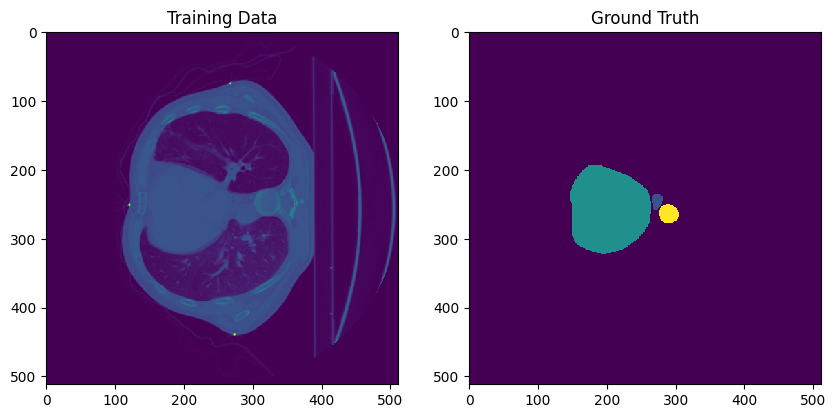

In [4]:
plot_slice(x, y, slice_idx=100)

In [ ]:

image, label = load_dataset('../data/Patient_01.nii', '../data/GT.nii') #shape(512,512,229)


tensor_x = torch.from_numpy(image).float()
tensor_y = torch.from_numpy(label).float()
X = tensor_x.permute(2, 0, 1).unsqueeze(1)  # x is now (229, 1, 512, 512)
Y = tensor_y.permute(2, 0, 1).unsqueeze(1)

#cropping function
X = F.interpolate(X, size=(256, 256), mode='bilinear', align_corners=False)  # x is now (229, 1, 256, 256) (229, 256, 256)
print(X.shape)
Y = F.interpolate(Y, size=(256, 256), mode='bilinear', align_corners=False)
print(X.shape)

dataset = CustomDataset(X, Y)
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

model = UNet()
criterion = torch.nn.CrossEntropyLoss()  # or any other applicable loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5  # Number of epochs
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in data_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        outputs = outputs.cpu()
        #predictions = torch.argmax(outputs, dim=1).float()
        loss = criterion(outputs, targets.squeeze().long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss -= loss.item()
        inputs.cpu()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(data_loader)}')

model.cpu()
